**PREDICTING SOLAR POWER GENERATION USING ML AND DL MODELS LEVERGAING HISTROICAL DATA **

In [ ]:
from datetime import datetime
import pandas as pd
from pvlive_api import PVLive
import pytz

# Initialize the PVLive API client
pvl = PVLive()

# Define the start and end dates for 2023 with timezone
utc = pytz.UTC
start_date = utc.localize(datetime(2023, 1, 1, 0, 30))  # 30-minute intervals
end_date = utc.localize(datetime(2023, 12, 31, 23, 30))

# Fetch data for GSP ID 30 with additional fields
data = pvl.between(
    start=start_date,
    end=end_date,
    entity_type="gsp",
    entity_id=30,
    extra_fields="capacity_mwp,installedcapacity_mwp,site_count",  # Include extra fields
    dataframe=True
)

# Display the data
print(data.head())

# Save the fetched data to a CSV file for future use
data.to_csv("gsp_30_2023_data_with_parameters.csv", index=False)
print("Data saved to 'gsp_30_2023_data_with_parameters.csv'.")



In [ ]:
import pandas as pd

# Ensure datetime_gmt is in datetime format
gsp_2023['datetime_gmt'] = pd.to_datetime(gsp_2023['datetime_gmt'])

# Group by date (ignoring time)
aggregated_data = gsp_2023.groupby(gsp_2023['datetime_gmt'].dt.date).agg({
    'gsp_id': 'first',        # Retain the gsp_id (value 30)
    'generation_mw': 'mean',  # Average of generation_mw
         # Average of bias_error
    'capacity_mwp': 'mean',   # Average of capacity_mwp
    'installedcapacity_mwp': 'mean',  # Average of installedcapacity_mwp
             # Average of lcl_mw
    'site_count': 'sum'    # Total site_count for the day
                          # Average of stats_error
                           # Average of ucl_mw
                             # Average of uncertainty_MW
}).reset_index()

# Rename the index column to 'date'
aggregated_data.rename(columns={'datetime_gmt': 'date'}, inplace=True)

# Display the first few rows
print(aggregated_data.head())


In [ ]:
gsp_node_data = pd.read_csv("gsp_gnode_directconnect_region_lookup.csv")
#Merge with the PV dataset to get lat and long
# Select only the relevant columns from gsp_node_data
gsp_node_subset = gsp_node_data[['gsp_id', 'gsp_lat', 'gsp_lon', 'region_name']]

# Merge the combined_data with the gsp_node_subset on gsp_id
merged_data = pd.merge(aggregated_data, gsp_node_subset, on='gsp_id', how='left')

# Display the first few rows of the merged data
print(merged_data.head())

In [ ]:
#Splitting the data into chuncks
import pandas as pd


# Define chunk size
chunk_size = 500

# Split into chunks and save as separate files
for i in range(0, len(merged_data ), chunk_size):
    chunk = merged_data.iloc[i:i + chunk_size]
    chunk.to_csv(f"gsp_2023_30_chunk_{i//chunk_size + 1}.csv", index=False)

print(f"Data split into {len(merged_data) // chunk_size + 1} chunks of size {chunk_size} (last chunk may be smaller).")

In [ ]:
import pandas as pd
import time
import os
from pynasapower.get_data import query_power
from pynasapower.geometry import point

# Load the chunk
chunk = pd.read_csv("gsp_2023_30_chunk_1.csv")

# Initialize output file
output_file = "weather_data_chunk_2023.csv"
if not os.path.exists(output_file):
    pd.DataFrame().to_csv(output_file, index=False)

# Define retry parameters
max_retries = 3
timeout_seconds = 10

# Process each row in the chunk
for index, row in chunk.iterrows():
    latitude = row["gsp_lat"]
    longitude = row["gsp_lon"]
    date = pd.to_datetime(row["date"]).date()  # Use the 'date' column instead

    gpoint = point(longitude, latitude, "EPSG:4326")

    for retry in range(max_retries):
        try:
            start_time = time.time()

            # Fetch weather data
            response = query_power(
                geometry=gpoint,
                start=date,
                end=date,
                community="ag",
                parameters=[],  # Fetch all available parameters
                temporal_api="daily",  # 'daily' temporal resolution
                spatial_api="point",
                format="json"
            )

            elapsed_time = time.time() - start_time

            # Skip if it takes too long
            if elapsed_time > timeout_seconds:
                print(f"Skipping row {index} due to timeout.")
                break

            # Extract weather parameters
            weather_data = {"date": row["date"]}  # Use 'date' instead of 'datetime_gmt'
            for key, values in response["properties"]["parameter"].items():
                weather_data[key] = list(values.values())[0]

            # Append to output
            weather_row = pd.DataFrame([weather_data])
            weather_row.to_csv(output_file, mode='a', header=not os.path.exists(output_file), index=False)

            print(f"Processed row {index} successfully.")
            break  # Exit retry loop if successful

        except Exception as e:
            print(f"Error processing row {index}, attempt {retry + 1}: {e}")
            if retry == max_retries - 1:
                print(f"Skipping row {index} after {max_retries} attempts.")


In [ ]:
# Reset the index to make sure the 'date' is not the index
weather_data_to_merge_2023.reset_index(drop=True, inplace=True)

# Assign meaningful column names
weather_data_to_merge_2023.columns = [
    'date',                  # Assuming the first column is the date
    'TOA_SW_DWN',            # Top-Of-Atmosphere Shortwave Downward Irradiance
    'ALLSKY_SFC_SW_DWN',     # All Sky Surface Shortwave Downward Irradiance
    'T2M',                   # Temperature at 2 Meters
    'T2M_MIN',               # Minimum Temperature at 2 Meters
    'T2M_MAX',               # Maximum Temperature at 2 Meters
    'T2MDEW',                # Dew/Frost Point at 2 Meters
    'WS2M',                  # Wind Speed at 2 Meters
    'PRECTOTCORR'            # Precipitation Corrected
]

# Convert the 'date' column to datetime
weather_data_to_merge_2023['date'] = pd.to_datetime(weather_data_to_merge_2023['date'])

# Ensure the 'date' column remains as a regular column
weather_data_to_merge_2023.set_index('date', inplace=False)

# Verify the data
print(weather_data_to_merge_2023.head())


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler


In [2]:
# 1. File Loading Function
def load_and_combine_files(file_paths):
    """
    Load multiple CSV files and combine them into a single DataFrame.

    Parameters:
    file_paths (list): List of file paths to load.

    Returns:
    pd.DataFrame: Combined DataFrame.
    """
    try:
        dataframes = [pd.read_csv(file) for file in file_paths]
        combined_data = pd.concat(dataframes, ignore_index=True)
        print("Files loaded and combined successfully.")
        return combined_data
    except Exception as e:
        print(f"Error loading files: {e}")
        return None

In [3]:
# Load datasets
file_paths = ["/content/sample_data/final_df_year_2022.csv",
              "/content/sample_data/final_df_year_2023.csv",
              "/content/sample_data/final_df_year_2024.csv"]
data = load_and_combine_files(file_paths)

Files loaded and combined successfully.


In [4]:
#drop unnecessary columns
cols_to_drop = ["gsp_id", "gsp_lat", "gsp_lon", "region_name"]
data = data.drop(columns=cols_to_drop)
data

,date,generation_mw,capacity_mwp,installedcapacity_mwp,site_count,TOA_SW_DWN,ALLSKY_SFC_SW_DWN,T2M,T2M_MIN,T2M_MAX,T2MDEW,WS2M,PRECTOTCORR
0,2022-01-01,2.027627,105.00778,110.72879,597658.0,6.85,2.02,11.08,10.16,12.75,10.30,4.76,0.39
1,2022-01-02,1.238680,105.00536,110.72879,580754.0,6.90,2.35,10.30,8.12,11.77,9.22,5.61,3.68
2,2022-01-03,1.118594,105.00310,110.72897,616761.0,6.96,1.92,8.12,7.33,9.52,7.61,4.40,0.19
3,2022-01-04,1.260356,105.01478,110.74307,131126.0,7.03,2.33,3.79,-0.24,7.34,2.72,3.60,1.68
4,2022-01-05,8.347555,105.04261,110.77333,506888.0,7.10,4.45,0.97,-0.51,5.48,0.06,3.84,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,2024-12-07,0.803690,144.72657,153.54804,626439.0,7.05,1.53,6.83,5.44,11.82,5.12,9.63,8.41
1067,2024-12-08,1.596905,144.72320,153.54804,687578.0,6.98,1.58,6.37,6.05,6.68,5.23,8.38,4.49
1068,2024-12-09,2.809982,144.71984,153.54804,680158.0,6.92,1.94,5.93,5.08,6.74,4.94,5.88,1.87
1069,2024-12-10,0.678044,144.71648,153.54804,692451.0,6.87,1.33,5.34,4.51,6.64,4.51,4.55,1.00


In [6]:
# 2. Data Preprocessing
def preprocess_data(data):
    """
    Preprocess the combined data: handle missing values, convert date, and add date features.

    Parameters:
    data (pd.DataFrame): Combined DataFrame.

    Returns:
    pd.DataFrame: Preprocessed DataFrame.
    """
    data['date'] = pd.to_datetime(data['date'])
    data['day'] = data['date'].dt.day
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year
    data['day_of_year'] = data['date'].dt.dayofyear

    # Drop unnecessary columns
    columns_to_drop = ['gsp_id', 'region_name', 'gsp_lat', 'gsp_lon']
    data = data.drop(columns=columns_to_drop, errors='ignore')

    # Handle missing values
    data = data.interpolate()  # Interpolation for numerical columns
    print("Preprocessing complete.")
    return data

data = preprocess_data(data)

Preprocessing complete.


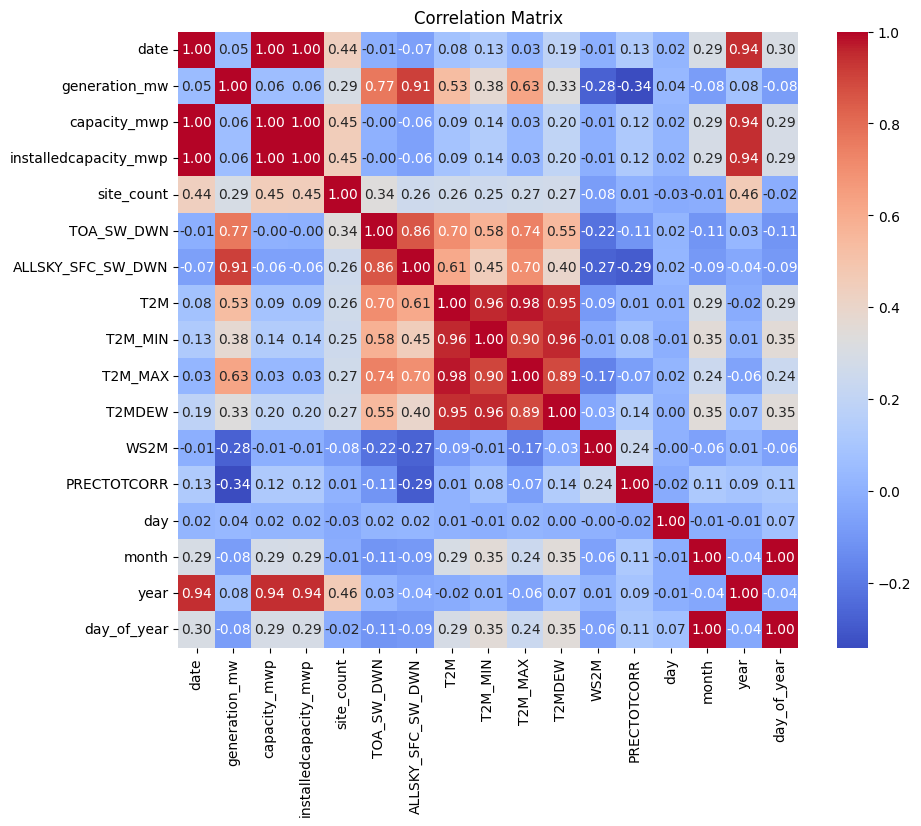

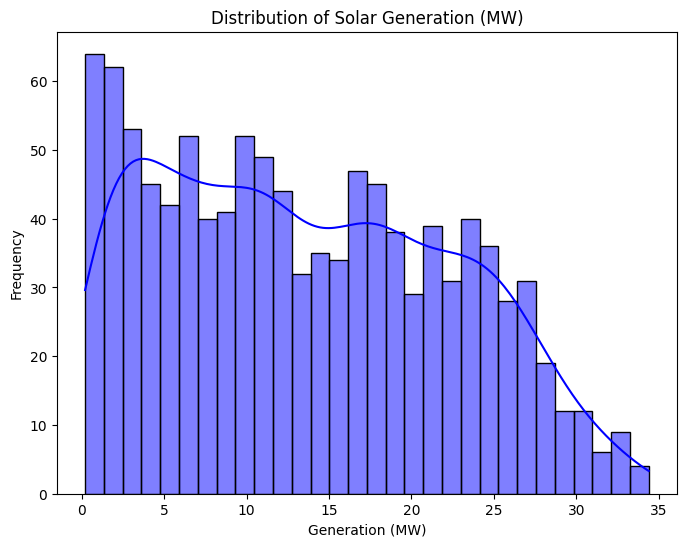

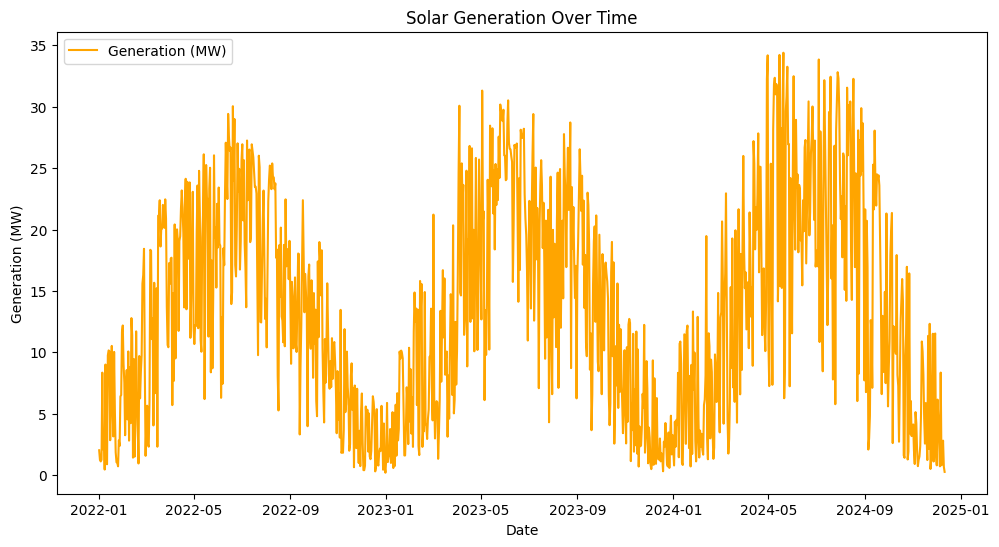

In [7]:
# 3. Exploratory Data Analysis (EDA)
def perform_eda(data):
    """
    Perform exploratory data analysis with visualizations.

    Parameters:
    data (pd.DataFrame): Preprocessed DataFrame.
    """
    # Correlation Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Matrix")
    plt.show()

    # Distribution of Solar Generation
    plt.figure(figsize=(8, 6))
    sns.histplot(data['generation_mw'], kde=True, bins=30, color="blue")
    plt.title("Distribution of Solar Generation (MW)")
    plt.xlabel("Generation (MW)")
    plt.ylabel("Frequency")
    plt.show()

    # Time-Series Plot
    plt.figure(figsize=(12, 6))
    plt.plot(data['date'], data['generation_mw'], label="Generation (MW)", color="orange")
    plt.title("Solar Generation Over Time")
    plt.xlabel("Date")
    plt.ylabel("Generation (MW)")
    plt.legend()
    plt.show()

perform_eda(data)


In [45]:
def split_data(data, target_variable='generation_mw', test_size=0.2):
    """
    Split the data into training and testing sets and include datetime-derived and cyclic features.

    Parameters:
    data (pd.DataFrame): Preprocessed data.
    target_variable (str): Target column name.
    test_size (float): Proportion of the dataset to include in the test split.

    Returns:
    X_train, X_test, y_train, y_test
    """
    target = data[target_variable]
    features = data.drop(columns=[target_variable])

    # Add datetime-derived features
    if 'date' in features.columns:  # Ensure 'date' column exists
        features['date'] = pd.to_datetime(features['date'], errors='coerce')
        features['day'] = features['date'].dt.day
        features['month'] = features['date'].dt.month
        features['year'] = features['date'].dt.year
        features['day_of_week'] = features['date'].dt.dayofweek
        features['is_weekend'] = (features['day_of_week'] >= 5).astype(int)

        # Add cyclic encoding for 'month' and 'day_of_week'
        features['sin_month'] = np.sin(2 * np.pi * features['month'] / 12)
        features['cos_month'] = np.cos(2 * np.pi * features['month'] / 12)
        features['sin_day_of_week'] = np.sin(2 * np.pi * features['day_of_week'] / 7)
        features['cos_day_of_week'] = np.cos(2 * np.pi * features['day_of_week'] / 7)

        # Drop original datetime and redundant columns
        features = features.drop(columns=['date', 'month', 'day_of_week'])

    # Split the data
    train_size = int(len(data) * (1 - test_size))
    X_train = features.iloc[:train_size].copy()
    X_test = features.iloc[train_size:].copy()
    y_train = target.iloc[:train_size]
    y_test = target.iloc[train_size:]

    # Return the splits
    return X_train, X_test, y_train, y_test


In [46]:
def train_linear_regression(X_train, X_test, y_train, y_test):
    """
    Train and evaluate a Linear Regression model with feature scaling.

    Returns:
        model: Trained model.
        y_train_pred: Predictions on the training set.
        y_test_pred: Predictions on the test set.
    """
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import StandardScaler

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform training data
    X_test_scaled = scaler.transform(X_test)       # Transform testing data

    # Train the model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Evaluate the model
    evaluate_model(y_train, y_train_pred, y_test, y_test_pred, model_name="Linear Regression")

    return model, y_train_pred, y_test_pred



In [48]:
def train_random_forest(X_train, X_test, y_train, y_test):
    """
    Train and evaluate a Random Forest model with hyperparameter tuning.

    Returns:
        model: Trained model.
        y_train_pred: Predictions on the training set.
        y_test_pred: Predictions on the test set.
    """
    from sklearn.ensemble import RandomForestRegressor

    # Train the model
    model = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate the model
    evaluate_model(y_train, y_train_pred, y_test, y_test_pred, model_name="Random Forest")

    return model, y_train_pred, y_test_pred


In [51]:
def train_xgboost(X_train, X_test, y_train, y_test):
    """
    Train and evaluate an XGBoost model with hyperparameter tuning.

    Returns:
        model: Trained model.
        y_train_pred: Predictions on the training set.
        y_test_pred: Predictions on the test set.
    """
    from xgboost import XGBRegressor

    # Train the model
    model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate the model
    evaluate_model(y_train, y_train_pred, y_test, y_test_pred, model_name="XGBoost")

    return model, y_train_pred, y_test_pred


In [43]:
def train_lstm_model(X_train, X_test, y_train, y_test, lookback=10, epochs=100, batch_size=32):
    """
    Train and evaluate an LSTM model for time-series prediction with optimized features and architecture.

    Parameters:
        X_train, X_test: Training and testing features (preprocessed).
        y_train, y_test: Training and testing target variables.
        lookback (int): Number of timesteps to look back for LSTM input.
        epochs (int): Number of epochs to train the model.
        batch_size (int): Batch size for training.

    Returns:
        dict: Training and testing RMSE, and the trained model history.
    """
    import numpy as np
    from sklearn.preprocessing import MinMaxScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from sklearn.metrics import mean_squared_error
    import matplotlib.pyplot as plt

    # Ensure the data is scaled to [0, 1]
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

    # Create LSTM-ready data
    def create_lstm_data(X, y, lookback):
        X_lstm, y_lstm = [], []
        for i in range(lookback, len(X)):
            X_lstm.append(X[i - lookback:i])
            y_lstm.append(y[i])
        return np.array(X_lstm), np.array(y_lstm)

    X_train_lstm, y_train_lstm = create_lstm_data(X_train_scaled, y_train_scaled, lookback)
    X_test_lstm, y_test_lstm = create_lstm_data(X_test_scaled, y_test_scaled, lookback)

    # Build the LSTM model
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train_lstm, y_train_lstm, validation_data=(X_test_lstm, y_test_lstm),
                        epochs=epochs, batch_size=batch_size, verbose=1)

    # Predictions
    y_train_pred_scaled = model.predict(X_train_lstm)
    y_test_pred_scaled = model.predict(X_test_lstm)

    # Inverse transform predictions
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

    y_train_actual = scaler_y.inverse_transform(y_train_lstm)
    y_test_actual = scaler_y.inverse_transform(y_test_lstm)

    # Evaluate the model
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))

    print(f"LSTM - Training RMSE: {train_rmse}")
    print(f"LSTM - Testing RMSE: {test_rmse}")

    # Plot predictions vs actual values
    plt.figure(figsize=(14, 7))
    plt.plot(range(len(y_test_actual)), y_test_actual, label="Actual", color="blue")
    plt.plot(range(len(y_test_actual)), y_test_pred, label="Predicted", color="orange")
    plt.title("LSTM: Actual vs Predicted")
    plt.xlabel("Time Index")
    plt.ylabel("Target Variable")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return {'train_rmse': train_rmse, 'test_rmse': test_rmse, 'history': history}


In [27]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(y_train, y_train_pred, y_test, y_test_pred, model_name="Model"):
    """
    Evaluate the model and display standardized metrics and plots.

    Parameters:
        y_train (array): Actual training target values.
        y_train_pred (array): Predicted training target values.
        y_test (array): Actual test target values.
        y_test_pred (array): Predicted test target values.
        model_name (str): Name of the model for display.
    """
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print results
    print(f"{model_name} - Train RMSE: {train_rmse:.4f}, R2: {train_r2:.4f}")
    print(f"{model_name} - Test RMSE: {test_rmse:.4f}, R2: {test_r2:.4f}")

    # Plot actual vs predicted for the test set
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(y_test)), y_test, label="Actual", color="blue")
    plt.plot(range(len(y_test)), y_test_pred, label="Predicted", color="orange")
    plt.title(f"{model_name}: Actual vs Predicted")
    plt.xlabel("Index")
    plt.ylabel("Target Variable")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


Linear Regression - Train RMSE: 3.0655, R2: 0.8604
Linear Regression - Test RMSE: 4.3894, R2: 0.8098


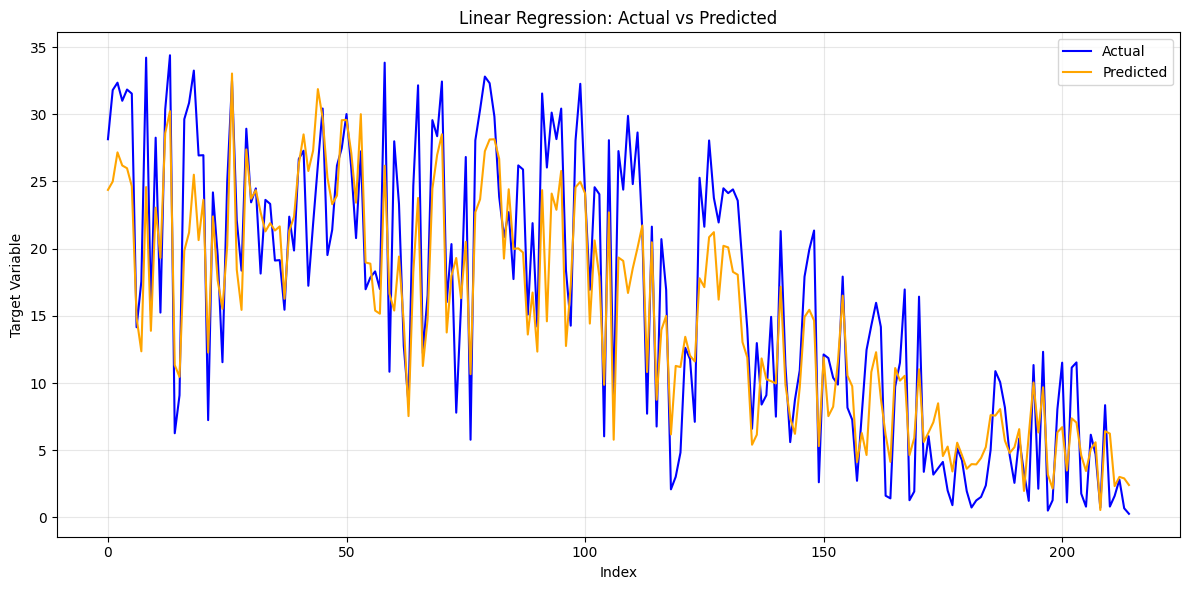

In [56]:
# Train and evaluate Linear Regression
lr_model, lr_y_train_pred, lr_y_test_pred = train_linear_regression(X_train, X_test, y_train, y_test)



Random Forest - Train RMSE: 1.0934, R2: 0.9822
Random Forest - Test RMSE: 4.3184, R2: 0.8159


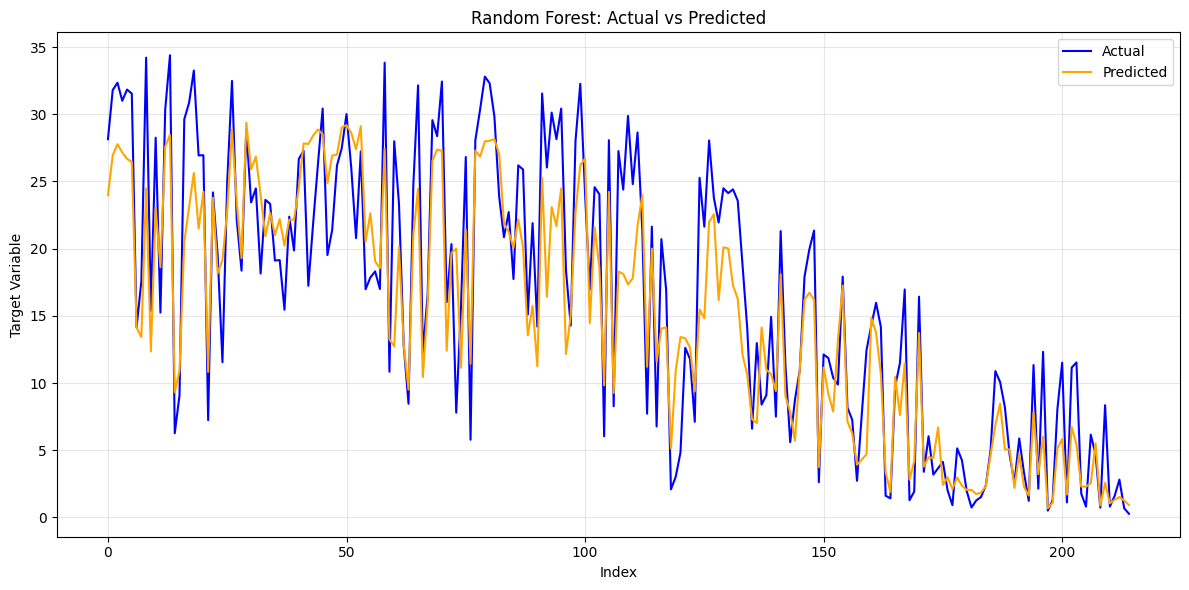

In [57]:
# Train and evaluate Random Forest
rf_model, rf_y_train_pred, rf_y_test_pred = train_random_forest(X_train, X_test, y_train, y_test)



XGBoost - Train RMSE: 0.2781, R2: 0.9989
XGBoost - Test RMSE: 4.1812, R2: 0.8274


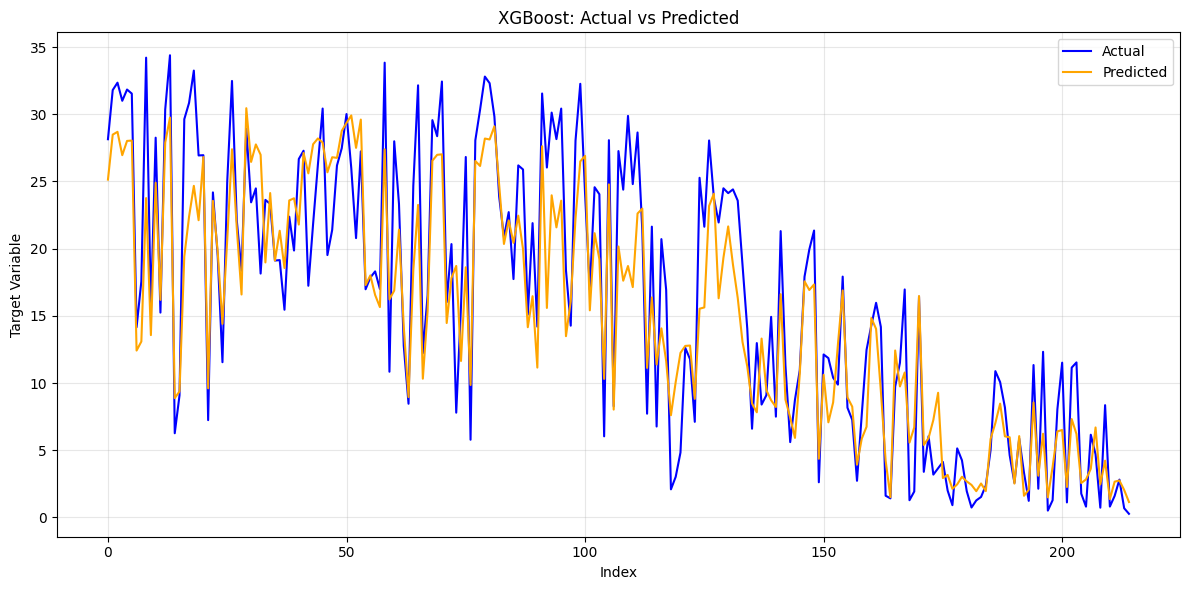

In [58]:
# Corrected unpacking
xgb_model, xgb_y_train_pred, xgb_y_test_pred = train_xgboost(X_train, X_test, y_train, y_test)



Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.1376 - val_loss: 0.0380
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0301 - val_loss: 0.0421
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0294 - val_loss: 0.0461
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0284 - val_loss: 0.0385
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0281 - val_loss: 0.0390
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0267 - val_loss: 0.0395
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0261 - val_loss: 0.0399
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0271 - val_loss: 0.0397
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0260 - val_loss: 0.0387
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0275 - val_loss: 0.0388
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0241 - val_loss: 0.0377
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0262 - val_l

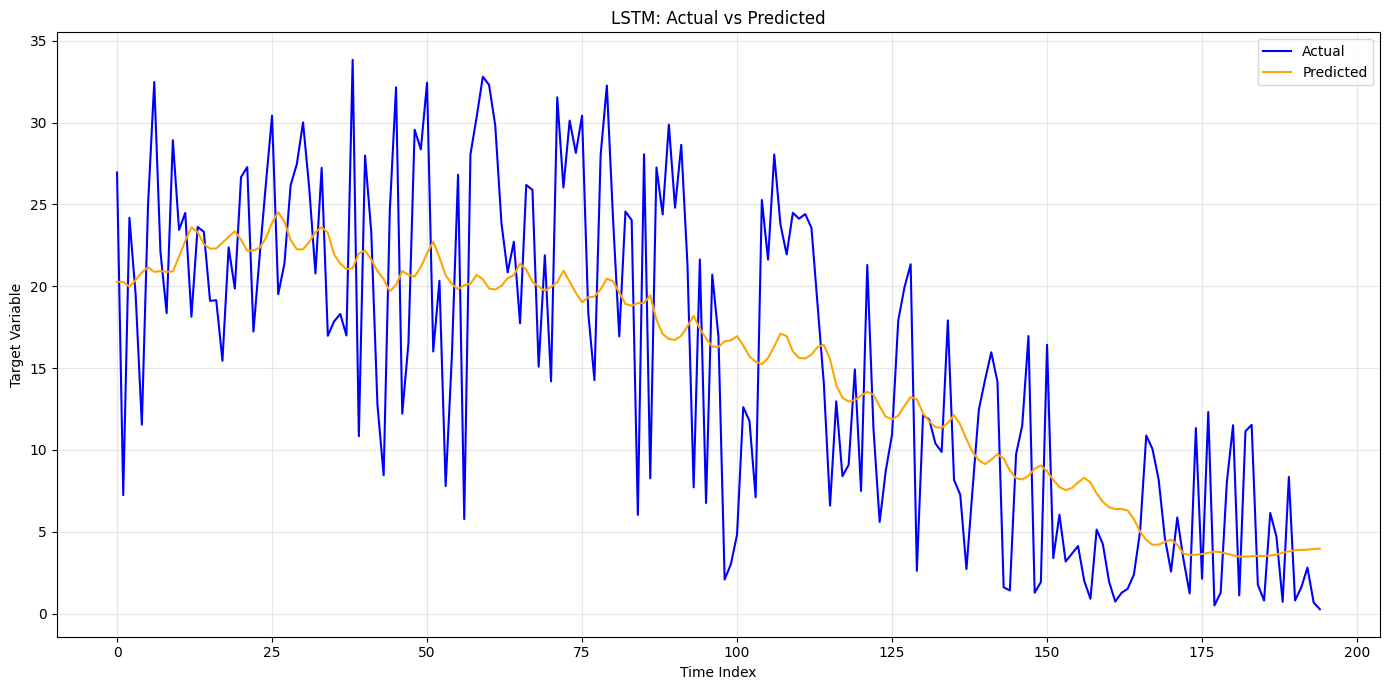

Training RMSE: 4.986411836589429
Testing RMSE: 6.590852712516323


In [55]:
# Assuming split_data has been used to generate the splits
X_train, X_test, y_train, y_test = split_data(data, target_variable='generation_mw')

# Train the LSTM model
lstm_results = train_lstm_model(X_train, X_test, y_train, y_test, lookback=20, epochs=50, batch_size=32)

# Print RMSE results
print("Training RMSE:", lstm_results['train_rmse'])
print("Testing RMSE:", lstm_results['test_rmse'])


